<a href="http://www.stfc.ac.uk/"> <img src="../img/STFCLargeColour.jpg" width="50%" align="left"/></a>
<a href="https://www.addopt.org/"><img src="../img/ADDoPT-logo-MAIN-with-text.png" width="300" height="200" align="right"/></a>


# Linear Modelling
-------------------------------

One of the most simple models to begin with is linear regression. 

In linear regression, there is a linear relationship between two variables. That is, one variable (Y) is linearly dependent on another (X).

Examples:

* height and weight
* height and shoe size


In [2]:
#import statements
import sys
sys.path.append("../lib/")
import models
import sklearn
import pandas
import matplotlib.pyplot as plt
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors
from sklearn.model_selection import train_test_split, cross_val_score
from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.metrics import r2_score

models.hideAnswers

Imported models functions


For this session we will be using a logP dataset. We have available to use the compound SMILES, and the associated logP measurement.

Our aim is to find a descriptor (or more) that can be used to create a linear model, and predict the LogP value.

The values are in raw form, and need to be converted to log values.

In [7]:
#read in the csv data
data = pandas.read_csv("../raw_data/logP.csv")
#rename the logPow column to Y - for ease
data = data.rename(columns={'logPow {measured, converted}':'y'})
#remove unwanted columns (we use axis=1 to denote columns)
data = data.drop("UNIT {logPow}", axis=1)
#transform the Y column using log10, and save over it
data["y"] = np.log10(data["y"])
#see the first 5 entries
data.head()

SMILES  N         y
0  [H]C1=C([H])N(C([H])=N1)C([H])([H])C1=C([H])C(...  1  1.599883
1                        OC(=O)COC1=C(Cl)C=C(Cl)C=C1  2  2.780317
2                                 NC1=CC=CC=C1C(O)=O  3  1.260071
3                               OC1=CC(Cl)=C(Cl)C=C1  4  3.389166
4                               OC1=CC(Cl)=CC(Cl)=C1  5  3.630428

## Convert to RDkit molecule, gather descriptors

We've already covered this in previous sessions.

In [8]:
#use an assert function to ensure a SMILES for every molecule
assert np.all(data["SMILES"].isnull()) == False

def toMolecule(smiles):
    ret = Chem.MolFromSmiles(smiles, sanitize=False) #generate the molecule
     #try to santise, if any errors capture them
    error = Chem.SanitizeMol(ret, sanitizeOps=Chem.rdmolops.SanitizeFlags.SANITIZE_ALL , catchErrors=True)
    #return the sanitised molecule, or None if the sanitisation did not work
    return ret if (Chem.rdmolops.SanitizeFlags.SANITIZE_NONE==error) else None 

#apply the toMolecule function to each SMILES  string, save it to the 'molecule' column0
data.insert(0, 'molecule', data['SMILES'].apply(toMolecule))
#remove any None molecules, reset the index to avoid any dataframe operation errors in the future
data = data.dropna(subset=['molecule']).reset_index(drop=True)
#see the first 5 entries
data.head()

molecule  \
0  <rdkit.Chem.rdchem.Mol object at 0x7f9a1185f440>   
1  <rdkit.Chem.rdchem.Mol object at 0x7f9a1185f580>   
2  <rdkit.Chem.rdchem.Mol object at 0x7f9a1185f4e0>   
3  <rdkit.Chem.rdchem.Mol object at 0x7f9a1185f530>   
4  <rdkit.Chem.rdchem.Mol object at 0x7f9a1185f620>   

                                              SMILES  N         y  
0  [H]C1=C([H])N(C([H])=N1)C([H])([H])C1=C([H])C(...  1  1.599883  
1                        OC(=O)COC1=C(Cl)C=C(Cl)C=C1  2  2.780317  
2                                 NC1=CC=CC=C1C(O)=O  3  1.260071  
3                               OC1=CC(Cl)=C(Cl)C=C1  4  3.389166  
4                               OC1=CC(Cl)=CC(Cl)=C1  5  3.630428

In [9]:
#repeated code from RDKit.ipynb
def FractionAromaticAtom(m): 
    return float( sum(1 for a in m.GetAtoms() if a.GetIsAromatic() ) ) / Descriptors.HeavyAtomCount(m)
assert 1.0 == FractionAromaticAtom(Chem.MolFromSmiles('c1ccccc1'))  
setattr(Descriptors, 'FractionAromaticAtom', FractionAromaticAtom)

def FractionAromaticValenceElectrons(m): 
    return float(sum(3 for b in m.GetBonds()if b.GetIsAromatic() )) / Descriptors.NumValenceElectrons(m)
assert 0.6 == FractionAromaticValenceElectrons(Chem.MolFromSmiles('c1ccccc1'))  
setattr(Descriptors, 'FractionAromaticValenceElectrons', FractionAromaticValenceElectrons)

def deltaEState(m): 
    return float(Descriptors.MaxEStateIndex(m) - Descriptors.MinEStateIndex(m))
assert 0.0 == deltaEState((Chem.MolFromSmiles('c1ccccc1')))
setattr(Descriptors, 'deltaEState', deltaEState)

allDescriptors =  [ d
    for d in dir(Descriptors) 
    if callable(getattr(Descriptors, d)) and not d in [
        '_isCallable', '_setupDescriptors', '_ChargeDescriptors', '_test','PropertyFunctor','_FingerprintDensity',
        '_runDoctests',
        # the following can return NaN:
        'MaxAbsPartialCharge', 'MaxPartialCharge', 'MinAbsPartialCharge', 'MinPartialCharge',
        # we will use the literature 'qed' rather than rdkit.
        'qed'
    ]
]

print("There are %i descriptors." %len(allDescriptors))

def describe(descriptor, molecules):
    return list(map(lambda m: getattr(Descriptors,descriptor)(m), molecules))

def makeDescDF(descriptors, molecules):
    """Gathers descriptors for molecules
    
    Keyword arguments:
    descriptors -- descriptors to be returned
    molecules -- molecules to be used
    """
    x = pandas.DataFrame()
    for d in descriptors:
        x[d] = describe(d,molecules) #returns a list that is saved as a new column
    return x

desc_df = makeDescDF(allDescriptors,data["molecule"])
assert len(data) == len(desc_df)

There are 198 descriptors.


In [10]:
#remove any columns where all values for a descriptor is 0.
desc_df = desc_df.loc[:,(desc_df != 0).any(axis=0)]
print("Removed any all 0 columns, %s descriptors remaining" %len(desc_df.columns))

Removed any all 0 columns, 177 descriptors remaining


## Split into training and test.

As there are few datapoints, we will use 1/3 splits.

In [11]:
#reset the index to 0 to len(data), to avoid any warnings.
data.reset_index(drop=True, inplace=True)
desc_df.reset_index(drop=True, inplace=True)

#split the data 2/3 training and 1/3 test data
training_data, test_data = train_test_split(data, test_size=1/3, random_state=1)
print("Training size:%i" %len(training_data))
print("Test size:%i" %len(test_data))

Training size:176
Test size:89


In [12]:
#save the descriptor values for the training and test, we can specify entries using the indexes
training_desc = desc_df.loc[training_data.index.tolist()]
test_desc = desc_df.loc[test_data.index.tolist()]

#save to pickle
training_data.to_pickle("../model_data/logP_train.p")
test_data.to_pickle("../model_data/logP_test.p")
training_desc.to_pickle("../model_data/logP_train_desc.p")
test_desc.to_pickle("../model_data/logP_test_desc.p")

# Linear Regression

We think of linear regression as the task of fitting a straight line to the data, showing the relationship between the independent variable (a descriptor) and a dependent variable (logP).

First we need to find any descriptors that could have a relationship with logP. We can do this by using correlation.

As we do not know the real distributions of our data or whether the relationships are indeed linear, we will use the Spearman's Rank Correlation coefficient, this is a non-parametric test that looks at the correlation between the ranks of the values of two variables.

$$Correlation = \frac{cov(R_x,R_y)}{\sigma{R_x}\cdot\sigma{R_y}}$$

Where $R_x$ and $R_y$ are the corresponding ranks of the variables.

Correlations of -1 or +1 imply an exact monotonic relationship (not necessarily linear). A positive correlation implies that as the X increases, as does the Y.

Spearmans rank correlation takes into account the standard deviation ($\sigma$) of the X and Y variables, so we must be sure to remove any features where standard deviation is 0. 
This means that there is only a single value for this descriptor across the entire dataset.

If left in, sklearn will give a warning about division.

In [13]:
#initialise empty list for appending
to_remove = []

#iterate through descriptors
for column in training_desc:
    #if all descriptor values for this descriptor are the same (only one unique value)
    if len(training_desc[column].unique()) == 1:
        #add the column to the list for removing
        to_remove.append(column)
        
print("Need to remove %s" %to_remove)
#remove the columns using the deleteColumns function
training_desc = models.deleteColumns(to_remove, training_desc)

Need to remove ['fr_C_S', 'fr_alkyl_carbamate', 'fr_azide', 'fr_thiophene']


In [14]:
y = training_data["y"]


#intialise an empty list for appending
rows = []

#iterate through the descriptors
for column in training_desc:
    #save the descriptor values
    x = training_desc[column]
    #perform spearmans correlation between the descriptor values and Y (log solubility)
    correlation, pvalue = spearmanr(x,y)
    #append the results to the lsit
    rows.append({
        'Descriptor':column,
        'Correlation':correlation,
        'Pvalue':pvalue
    })

In [15]:
#convert our results to a pandas dataframe
correlations = pandas.DataFrame(rows)
#ensure no correlations have a null value (did not work)
assert len(correlations[correlations["Correlation"].isnull()]) == 0
#show the first 5 entries
correlations.head()

Correlation Descriptor        Pvalue
0    -0.312803   BalabanJ  2.370539e-05
1     0.267120    BertzCT  3.385866e-04
2     0.291287       Chi0  8.773805e-05
3     0.324600      Chi0n  1.106602e-05
4     0.408491      Chi0v  1.822007e-08

If the correlations are relatively weak (e.g. -0.5 to +0.5), but the p values are relatively low, this means that the variables are weakly correlated, but the probability of unrelated variables producing the same correlation is very low.

However, because we have performed multiple testing, we need to apply a correction to make sure that we are not finding these simply by chance.

There are two methods, Bonferroni and Benjamini-Hochberg. We won't cover them here, but we will use the Bonferroni correction. (If you wish, [here's](https://www.stat.berkeley.edu/~mgoldman/Section0402.pdf) a useful description of the multiple testing problem).

Whereas we would usually accept a result as significant if the p-value ($P_{crit}$) is less than 0.05, the bonferroni correction ($P_{bonf}$) adjusts this critical value according to:

$$P_{bonf} = \frac{P_{crit}}{N}$$

In [16]:
#calculate the critical value using the equation above
critical_value = 0.05 / len(correlations)
print("Critical value is %0.4f"%critical_value)

Critical value is 0.0003


Now let's remove any relationships that are not significant, and let's see which descriptors could be used!

In [19]:
#perform a test to compare the p value with the critical value, select only those that pass.
significant_correlations = correlations[correlations["Pvalue"] < critical_value]

#add a column 'AbsoluteCorrelation', containing the absolute correlation for each descriptor with Y
significant_correlations.insert(0, "AbsoluteCorrelation", np.abs(significant_correlations["Correlation"]))
#sort the dataframe by descending absolute correlation, see the first 10 entries
significant_correlations.sort_values(by="AbsoluteCorrelation", ascending=False).head(10)

AbsoluteCorrelation  Correlation              Descriptor        Pvalue
44              0.891931     0.891931                 MolLogP  7.127828e-62
73              0.617614     0.617614               PEOE_VSA6  6.857876e-20
26              0.574984    -0.574984        FpDensityMorgan1  7.092922e-17
134             0.560474     0.560474              fr_benzene  6.028829e-16
52              0.560474     0.560474  NumAromaticCarbocycles  6.028829e-16
74              0.514454     0.514454               PEOE_VSA7  2.801477e-13
95              0.500055     0.500055              SlogP_VSA6  1.593942e-12
85              0.481574     0.481574                SMR_VSA7  1.321944e-11
27              0.460765    -0.460765        FpDensityMorgan2  1.235996e-10
45              0.455705     0.455705                   MolMR  2.081423e-10

As expected, MolLogP has a very high correlation with LogP - but we won't use this to predict LogP as this is cheating!

The next best is PEOE_VSA6.

"[PEOE](https://www.chemcomp.com/journal/descr.htm). The Partial Equalization of Orbital Electronegativities (PEOE) method of calculating atomic partial charges [Gasteiger 1980] is a method in which charge is transferred between bonded atoms until equilibrium. To guarantee convergence, the amount of charge transferred at each iteration is damped with an exponentially decreasing scale factor. The amount of charge transferred, $dq_{ij}$, between atoms $i$ and $j$ when $X_i > X_j$ is

$$dq_{ij} = \frac{1}{2k} \cdot \frac{X_i - X_j}{X_j^+}$$

where $X_j^+$ is the electronegativity of the positive ion of atom $j$; $X_i$ is the electronegativity of atom $i$ (quadratically dependent on partial charge); and $k$ is the iteration number of the algorithm. The PEOE charges depend only on the connectivity of the input structures: elements, formal charges and bond orders. Descriptors using the PEOE charges are prefixed with PEOE_." 

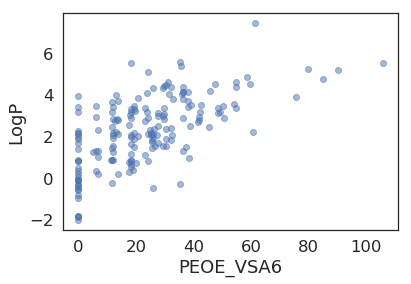

In [21]:
#plot the values for PEOE_VSA6 against the Y values
descriptor = 'PEOE_VSA6'
x = training_desc[descriptor]
plt.scatter(x,y, alpha=0.5)
plt.xlabel(descriptor)
plt.ylabel("LogP")
plt.show()

There are various ways of fitting a straight line to this data:
    
* Draw a random line between points
* Draw a line connecting the first and last points
* Draw a line that fits all the points the best it can.

In Linear Regression modelling, it is typical to use ordinary least squares (OLS) as a method for drawing a line of best fit on the data.

[OLS](https://en.wikipedia.org/wiki/Ordinary_least_squares) works by minimising the sum of squares of the differences between the observed Y value and those predicted by the linear function. 

Y = 0.0549X + 1.0306


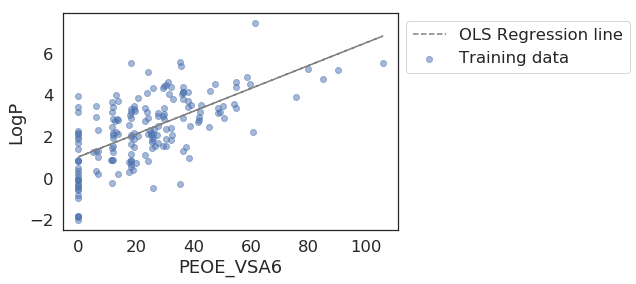

In [22]:
#as we are only using a single descriptor, we have to reshape so that the model understands it is one feature with many samples
#rather than one sample with many features
x = training_desc["PEOE_VSA6"].values.reshape(-1,1)
y = training_data["y"]

#fit the model, save to a variable
model = LinearRegression().fit(x,y)
#print the coefficient and intercepts
print("Y = %0.4fX + %0.4f" %(model.coef_,model.intercept_))
#predict the values of Y using the descriptor value
pred_y = model.predict(x)

#plot the descriptor values vs the actual Y
plt.scatter(x,y, alpha=0.5, label="Training data")
#plot a line for the descriptor values against the predicted value
plt.plot(x,pred_y,color="grey",linestyle="dashed", label="OLS Regression line")
#add relevant labels and legend
plt.xlabel(descriptor)
plt.ylabel("LogP")
plt.legend(bbox_to_anchor=(1,1))
plt.show()

## Cross validation
To assess how well this model performs, we use cross validation. As it is a regression model, we will assess the performance using the $R^2$.

In [24]:
#fit our model using all PEOE_VSA6 values
model.fit(x,y)
#calculate the r2 score between the predicted Y and the actual Y values
print("Non-cross validated score on entire training set: %0.4f" % r2_score(y,model.predict(x)))

Non-cross validated score on entire training set: 0.3993


In [25]:
#as we are only using a single descriptor, we have to reshape so that the model understands it is one feature with many samples
#rather than one sample with many features
x = training_desc["PEOE_VSA6"].values.reshape(-1,1)
y = training_data["y"]

from sklearn.model_selection import ShuffleSplit

#Our dataset size is very small, so whilst still doing 10 folds, we want half of the data to be used in each fold.
#As our test data will be predicted from a model that is fit to the entire data, we want to incorporate as much of the data
# into each CV as possible, whilst still maintaining a robust CV (low STD).

#declare the cv to be used, if this is an integer, it will perform 10-fold cv. 
#Using Shufflesplit means we can define half the data to be in each split
cv = ShuffleSplit(n_splits=10, train_size=0.5, test_size=0.5)

#save the model (untrained this time)
model = LinearRegression()
#calculate the scores. There will be 10 scores, one for each split
scores = cross_val_score(model, x, y, cv=cv, scoring="r2")
print(scores)
#calculate standard deviation and mean of the scores
print("STD: %0.4f" %np.std(scores))
print("R2 for cross validation: %0.4f" %np.mean(scores))

[0.33845556 0.43423625 0.42736544 0.42635323 0.33279391 0.36931447
 0.43843674 0.34435872 0.404279   0.36327402]
STD: 0.0404
R2 for cross validation: 0.3879


## Why do we use cross validation?

Let's see the results for the test set.

In [27]:
#fit the model to all training data (as we saved over it previously)
model.fit(x,y)
#load in the test data and descriptor values
test_desc = pandas.read_pickle("../model_data/logP_test_desc.p")
test_data = pandas.read_pickle("../model_data/logP_test.p")

test_desc = test_desc[training_desc.columns.tolist()] #ensure same descriptors are used

#save the x data, again reshape as we are only using one feature
testx = test_desc["PEOE_VSA6"].values.reshape(-1,1)
#calculate r2_score between the predicted and actual values for the test set
print("R2 for test set: %0.4f" % r2_score(test_data["y"], model.predict(testx)))

R2 for test set: 0.3428


The score for the cross validation set should be somewhere between the score for the whole training set and the score for the test set. It is an approximate measure of how much we are [overfitting](Overfitting.ipynb) on our training set.

The main reason to do this is to guide us in the modelling process, as any use of the test set in the modelling risks us overfitting to the test set too!

We will continue as if we haven't seen the test set already, as it isn't usually a part of the modelling process.

This isn't a particularly great model. We can try and build on this model by modelling the residuals. We can use correlation again to select the second feature

In [28]:
#fit the model to the PEOE_VSA6 training data
model.fit(x,y)
#predict the Y values
pred_y = model.predict(x)
#calculate the resiudals
residuals = y - pred_y

#initialise an empty list for appending to
rows = []

#iterate through descriptors
for column in training_desc:
    #save x values (we save as 'a' as we are already using 'x' for a variable)
    a = training_desc[column]
    #calculate spearmans correlation between the residuals of the previous model and 'a'
    correlation, pvalue = spearmanr(a,residuals)
    #append the results to the list
    rows.append({
        'Descriptor':column,
        'Correlation':correlation,
        'Pvalue':pvalue
    })
    
#convert results to a pandas dataframe
residual_correlations = pandas.DataFrame(rows)
#calculate critical value as above
critical_value = 0.05 / len(residual_correlations)
print("Critical value is %0.4f"%critical_value)
#select only those descriptors that have a significant p value (is less than the critical value)
significant_correlations = residual_correlations[residual_correlations["Pvalue"] < critical_value]

#calculate the absolute correlation, save to a new column
significant_correlations.insert(0, "AbsoluteCorrelation", np.abs(significant_correlations["Correlation"]))

#sort dataframe in descending absolute correlation, showing the first 10 entries
significant_correlations.sort_values(by="AbsoluteCorrelation", ascending=False).head(10)

Critical value is 0.0003


AbsoluteCorrelation  Correlation              Descriptor        Pvalue
44              0.587902     0.587902                 MolLogP  9.635800e-18
74              0.483350     0.483350               PEOE_VSA7  1.084718e-11
56              0.313508    -0.313508              NumHDonors  2.266972e-05
69              0.302165    -0.302165               PEOE_VSA2  4.585749e-05
47              0.298000    -0.298000               NHOHCount  5.896872e-05
26              0.280476    -0.280476        FpDensityMorgan1  1.629988e-04
52              0.279279     0.279279  NumAromaticCarbocycles  1.742985e-04
134             0.279279     0.279279              fr_benzene  1.742985e-04

PEOE_VSA7 is the next best descriptor correlated well with the residuals from the model. We will use this as our second feature.

In [29]:
y = training_data["y"]
#we do not need to reshape now as we are using more than one feature
x = training_desc[["PEOE_VSA6","PEOE_VSA7"]]
#save a new model instance (untrained)
model = LinearRegression()
#perform cross validation, this time using 10-fold cross validation, 
#90% of data is in the training, whilst 10% of the data is in the validation in each split
scores = cross_val_score(model, x, y, cv=10, scoring="r2")
#fit the model to all data
model.fit(x,y)

print("Y = %0.4fX(1) + %0.4fX(2) + %0.4f" %(model.coef_[0],model.coef_[1],model.intercept_))
#find the average validation score
print("R2: %0.3f" %np.average(scores))

Y = 0.0460X(1) + 0.0292X(2) + 0.2989
R2: 0.450


Adding a feature will never reduce the R2, if the feature is particularly helpful it will dramatically increase the R2, however even if there is no causal relationship the R2 will still increase possibly by chance.

One of the inherent problems with linear regression, particularly OLS, that as the number of features increase, you are more likely to overfit. This can be due to the magnitude of the coefficients. The magnitude of a coefficient will increase the more features are involved in the model/the more complex the model becomes.

Regularisation regression techniques penalise the magnitude of the coefficients of features, whilst also minimising the error between the predicted and the actual observations.

1. Ridge regression:
    * Performs $L_2$ regularisation, adding a penalty equivalent to the square of magnitude of the coefficients
    * Minimisation objective = least squares objective + $\alpha$(sum of square of the coefficients)
2. Lasso regression:
    * Performs $L_1$ regularisation, adding a penalty equivalent to the absolute value of the magnitude of the coefficients
    * Minimisation objective = least squares objective + $\alpha$(sum of absolute value of the coefficients)
    
Recall that the least squares objective is to minimise the residual sum of squares between each point and the predicted value. For now we will focus on Lasso regression, which uses L1 regularisation, but for most models either L1 or L2 regularisation can be used.

$$L_1(x) = \sum {|x_i|}$$

$$L_2(x) = \sqrt{\sum {x_i}^2}$$

Where $x_i$ is a coefficient of the variable(s) $x$.

## Lasso regression

Least Absolute Shrinkage and Selection Operator performs $L_1$ regularisation. This involves added a penalty for the sum of absolute value of the coefficients.

For example, if our model were:

Y = 10x + 30x2 + 2.5

The penalty would be 40 (the sum of absolute values for 10 and 30).

We can balance the RSS (residual sum of squares) and the $L_1$ objective using a parameter $\alpha$, so that the overall objective is:

$$Lasso_{obj} = RSS + \alpha \cdot L_1$$

Setting $\alpha$:

* $\alpha = 0$, same coefficients as OLS
* $\alpha = \infty$, all coefficients are 0.
* $0 < \alpha < \infty$, coefficients between 0 and those of OLS.

In order for the model to converge and attempt to achieve the objective, we must allow a number of iterations. You may observe some warnings due to using low alpha values.

In [31]:
#save the number of iterations
num_iterations = 100000

#declare a list of alpha values to use (the amount of regularisation), we can also specify the number of folds to use for CV
model_lasso = LassoCV(alphas=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0], cv=10)
#fit the model to all the training data
model_lasso.fit(training_desc,training_data["y"]) #using all the features.
#print the alpha value that gave the best r2
print("Optimised alpha is %0.2f" %model_lasso.alpha_)
#show the coefficient for each feature using the optimised model
model_lasso.coef_

/root/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/root/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/root/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/root/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want t

/root/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/root/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/root/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/root/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want t

/root/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/root/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/root/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/root/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want t

Optimised alpha is 0.10


/root/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/root/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/root/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/root/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want t

array([ 0.00000000e+00, -8.17626220e-05,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00, -1.12164312e-02, -2.94875624e-04,
       -0.00000000e+00, -1.33742786e-02,  0.00000000e+00, -0.00000000e+00,
        1.04901721e-02,  9.51410529e-03,  0.00000000e+00,  0.00000000e+00,
        2.43559125e-02,  8.03750279e-03, -0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
       -0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -1.35563104e-14,
        0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  1.43685814e-02,
       -0.00000000e+00, -0.00000000e+00,  0.00000000e+00, -0.00000000e+00,
        0.00000000e+00,  2.10651624e-02, -1.81989342e-03, -0.00000000e+00,
        0.00000000e+00, -0.00000000e+00, -0.00000000e+00, -0.00000000e+00,
        0.00000000e+00, -

You will notice that a lot of the coefficients have been reduced to 0, meaning that these particular features have been excluded from the model. This is a key difference between Ridge and Lasso regression. Ridge will use all of the features in the model, so benefits include coefficient shrinkage and reducing model complexity. In Lasso, as some of the coefficients become exactly zero, some features are removed from the model, and so it can be used for feature selection.

In [27]:
#Which descriptor coefficients were not reduced to 0?
training_desc.columns[model_lasso.coef_!=0]

Index(['BertzCT', 'EState_VSA1', 'EState_VSA10', 'EState_VSA2', 'EState_VSA5',
       'EState_VSA6', 'EState_VSA9', 'ExactMolWt', 'Ipc', 'LabuteASA', 'MolMR',
       'MolWt', 'PEOE_VSA1', 'PEOE_VSA11', 'PEOE_VSA14', 'PEOE_VSA2',
       'PEOE_VSA4', 'PEOE_VSA5', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8',
       'PEOE_VSA9', 'SMR_VSA10', 'SMR_VSA3', 'SMR_VSA4', 'SMR_VSA5',
       'SMR_VSA7', 'SlogP_VSA1', 'SlogP_VSA10', 'SlogP_VSA11', 'SlogP_VSA12',
       'SlogP_VSA2', 'SlogP_VSA3', 'SlogP_VSA5', 'SlogP_VSA6', 'SlogP_VSA8',
       'TPSA', 'VSA_EState5', 'VSA_EState9'],
      dtype='object')

In [28]:
print("R2 is: %0.4f" %model_lasso.score(training_desc, training_data["y"]))

R2 is: 0.8376


You may find that some features are considered important by Lasso that weren't identified in the correlations above, this is likely due to hidden features.

A combined regression may find deeper patterns in these features than individual tests for correlation.

## Ridge regression

Let's see how ridge regression performs in contrast. Recall that in Ridge regression, we are performing $L_2$ regularisation, so the coefficients never become absolute 0. Again, you may see some warnings.

In [33]:
#specify amount of regularisation to use, and cv folds
model_ridge = RidgeCV(alphas=[0.5,0.6,0.7,0.8,0.9,1.0], cv=10, gcv_mode='svd')
model_ridge.fit(training_desc,training_data["y"]) #using all the features.
#show the coefficient for each descriptor
model_ridge.coef_

/root/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/root/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/root/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/root/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/root/miniconda3/lib/python3.6/site-packages/skl

/root/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/root/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/root/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/root/miniconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "
/root/miniconda3/lib/python3.6/site-packages/skl

array([ 1.32163551e-01, -1.21840316e-03, -1.98906525e-02,  3.78695051e-02,
        7.08802731e-02,  5.18371045e-02,  3.93070582e-01, -7.81683556e-01,
        9.41886540e-02,  4.03724274e-01, -6.57592914e-01,  2.69625120e-01,
       -1.19934858e-01, -9.58963567e-02,  4.01982012e-03,  2.77903288e-02,
       -1.75333668e-01,  1.37050191e-03,  2.37467505e-02,  1.62728789e-02,
        2.52710053e-02,  2.35909799e-02,  1.68211505e-02,  3.83326046e-03,
        1.03039460e-01,  4.74818230e-02, -3.16950242e-01, -1.86917184e-01,
        1.41950787e-01,  2.73061648e-01,  1.11399618e-01, -2.82878527e-01,
       -8.02792866e-01,  7.80003620e-02,  1.32469797e-02, -6.86208964e-14,
        7.77416256e-02,  4.31896581e-01, -5.17600113e-01,  9.16911366e-02,
       -3.42706484e-02, -3.42706484e-02,  4.43306065e-01, -1.13986227e-01,
        7.81359548e-01, -2.03626879e-01, -5.65880955e-02,  1.21347628e-01,
       -1.77883964e-01,  5.36908025e-02,  1.70600961e-02,  7.07508987e-02,
       -1.17307930e-01, -

In [34]:
print("R2 is: %0.4f" %model_ridge.score(training_desc, training_data["y"]))

R2 is: 0.9569


This model looks great! But with so many features, is it likely to be overfitting?

<div class="alert alert-warning" role="alert">
<b>Exercise:</b> Test these models using our test data.<br>
<ol>
    <li> Load in the test datasets created earlier in the notebook.</li>
    <li> Make sure the test descriptors are the same as those used for training - We have given the code for this.</li>
    <li> Make predictions using both trained models. Hint: Use model_name.predict(data) </li>
    <li> Calculate the R2 between the predicted and actual values. Hint: use r2_score(y_true,y_pred)</li>
</ol>
</div>

In [ ]:
#load in the test data
test_desc = None
test_data = None

test_desc = test_desc[training_desc.columns.tolist()] #ensure same descriptors are used
#predict the test Y using the ridge and lasso models respectively
ridge_predictions = None
lasso_predictions = None

#calculate the r2 for the test predictions and the test Y for each model respectively
ridge_r2 = None
lasso_r2 = None

print("Lasso regression:\n Training score = %0.4f\n Test score = %0.4f\n" %(
    model_lasso.score(training_desc, training_data["y"]),
    lasso_r2))

print("Ridge regression:\n Training score = %0.4f\n Test score = %0.4f\n" %(
    model_ridge.score(training_desc, training_data["y"]),
    ridge_r2))

In [3]:
display(models.tag)
#test_desc = pandas.read_pickle("../model_data/logP_test_desc.p")
#test_data = pandas.read_pickle("../model_data/logP_test.p")

#test_desc = test_desc[training_desc.columns.tolist()] #ensure same descriptors are used

#ridge_predictions = model_ridge.predict(test_desc)
#lasso_predictions = model_lasso.predict(test_desc)

#ridge_r2 = r2_score(test_data["y"],ridge_predictions)
#lasso_r2 = r2_score(test_data["y"],lasso_predictions)

#print("Lasso regression:\n Training score = %0.4f\n Test score = %0.4f\n" %(
#    model_lasso.score(training_desc, training_data["y"]),
#    lasso_r2))

#print("Ridge regression:\n Training score = %0.4f\n Test score = %0.4f\n" %(
#    model_ridge.score(training_desc, training_data["y"]),
#    ridge_r2))

<div class="alert alert-warning" role="alert">
<b>Question:</b>
<ol>
    <li> Why is ridge so much higher?</li>
    <li> When would Lasso be preferred over ridge?</li>
    <li> Why would relationships between features affect ridge more than lasso? </li>
</ol></div>    

In [4]:
display(models.tag)

#1) Ridge has optimised the model to include all of the features, it is therefore likely to be much more susceptible to overfitting
#2) As lasso uses much fewer features, it makes the model much simpler to interpret. We can have a good idea on which descriptors could influence the logP
#3) As you noticed we received a warning about our ridge model. The algorithm has found many of our features to have a relationship with one another,
# making the model potentially unstable, especially to large fluctuations in particular features.

## Further reading

For more information on the topics covered here:
    
1. [Lasso Tutorial](https://www.analyticsvidhya.com/blog/2016/01/complete-tutorial-ridge-lasso-regression-python/)
2. [Regression shrinkage and selection](https://www.jstor.org/stable/2346178?seq=1#page_scan_tab_contents)


[Up](../Welcome.ipynb)<br> [Back](PreparingData.ipynb) [Next](Overfitting.ipynb) <br>

---------------------------------------------------
Copyright STFC 2018